In [1]:
import utulek
import torch
import numpy as np
import random
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
random.seed(0)

np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [2]:
batch_size = 100
epochs = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

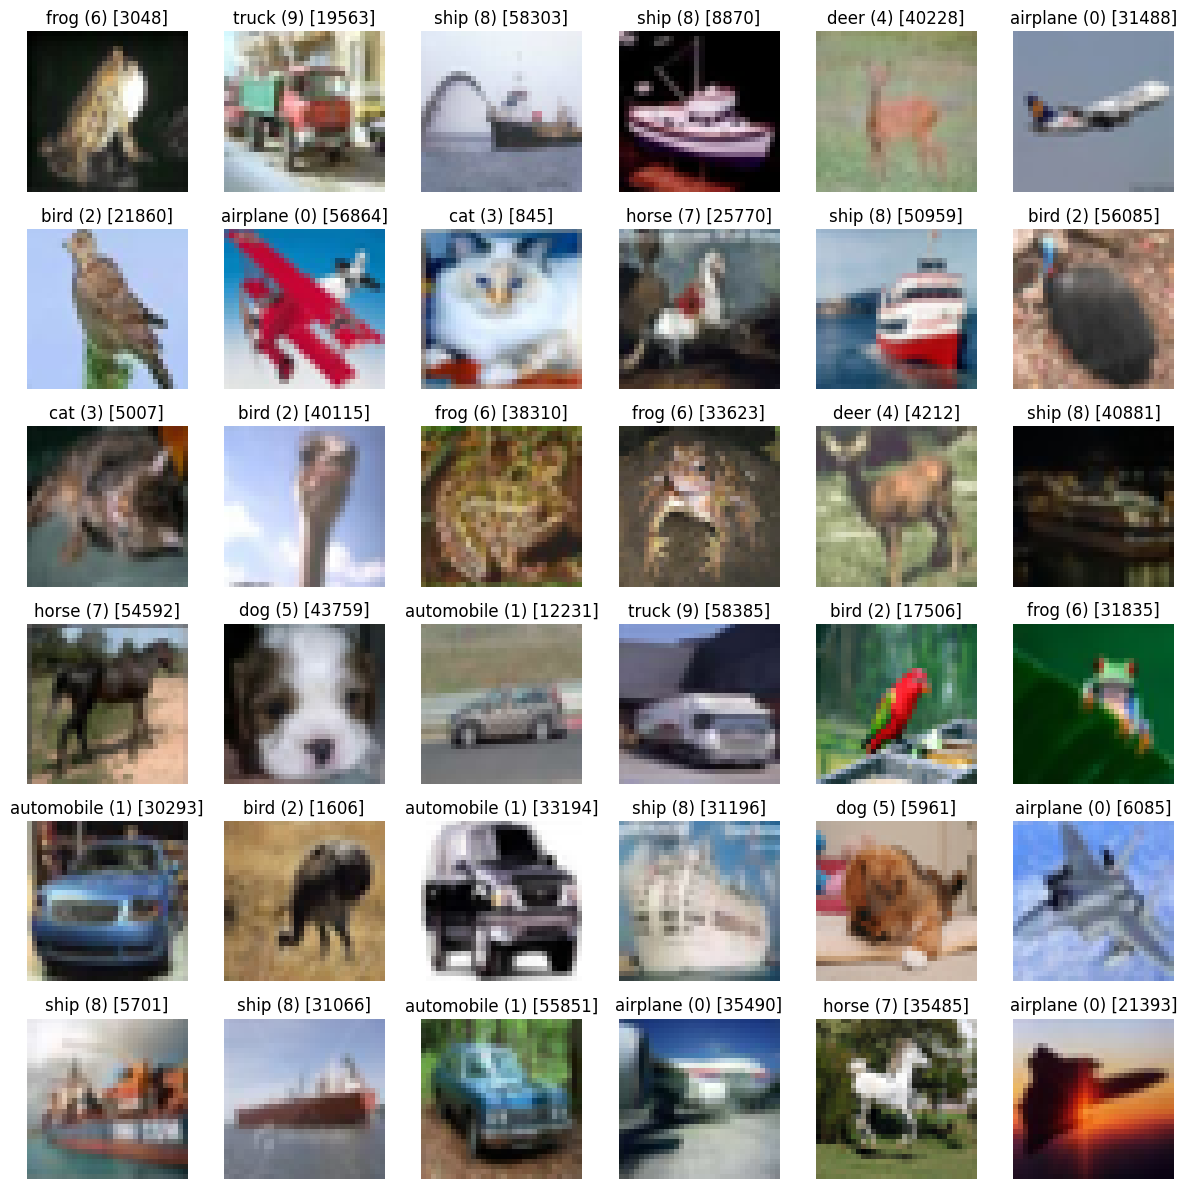

In [3]:
X, Y, labels = utulek.fetch_ds_cifar_10()
X = X.astype(np.float32) / 255
utulek.show_img_ds(X, Y, labels=labels, shape=(6, 6))
X = X.transpose((0, 3, 1, 2))
X_train, Y_train = X[:50000], Y[:50000]
X_test, Y_test = X[50000:], Y[50000:]
X_orig, Y_orig = X, Y

class Cifar10DatasetTrain(torch.utils.data.Dataset):
    def __len__(self):
        return len(X_train)

    def __getitem__(self, idx):
        return X_train[idx], Y_train[idx]
    

class Cifar10DatasetTest(torch.utils.data.Dataset):
    def __len__(self):
        return len(X_test)

    def __getitem__(self, idx):
        return X_test[idx], Y_test[idx]
    

train_dataset = Cifar10DatasetTrain()
test_dataset = Cifar10DatasetTest()

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

for X, Y in train_loader:
    X_shape = (X.shape, X.dtype)
    Y_shape = (Y.shape, Y.dtype)
    break
    
print(X_shape, Y_shape)

(torch.Size([100, 3, 32, 32]), torch.float32) (torch.Size([100]), torch.uint8)


In [5]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=5),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 256, kernel_size=5),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(2, stride=3),
            torch.nn.Flatten(),
            torch.nn.Linear(16384, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, 10)
        )

    def forward(self, X):
        return self.network(X)


print(model := NeuralNetwork().to(device))

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=16384, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
%%time

from tqdm.auto import tqdm
import matplotlib.pyplot as plt


calc_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

def train():
    model.train()
    data = iter(train_loader)
    XY_next = data.next()
    XY_next = [i.to(device, non_blocking=True) for i in XY_next]
    
    for i in range(len(train_loader)):
        X, Y = XY_next
        if i + 1 != len(train_loader):
            XY_next = data.next()
            XY_next = [i.to(device, non_blocking=True) for i in XY_next]
        
        pred = model(X)
        loss = calc_loss(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def eval():
    model.eval()
    c_test = len(test_loader.dataset)
    correct = 0
    
    with torch.no_grad():
        data = iter(test_loader)
        XY_next = data.next()
        XY_next = [i.to(device, non_blocking=True) for i in XY_next]
        
        for i in range(len(test_loader)):
            X, Y = XY_next
            if i + 1 != len(test_loader):
                XY_next = data.next()
                XY_next = [i.to(device, non_blocking=True) for i in XY_next]

            pred = model(X).argmax(axis=1)
            correct += (pred == Y).sum().item()

    return correct / c_test

    
accuracies = []
    

for epoch in tqdm(range(epochs)):
    train()
    accuracies.append(eval() * 100)
    tqdm.write(f"Accuracy: {accuracies[-1]:.2f}%", end="\r")

  0%|          | 0/16 [00:00<?, ?it/s]

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

Accuracy: 68.87%


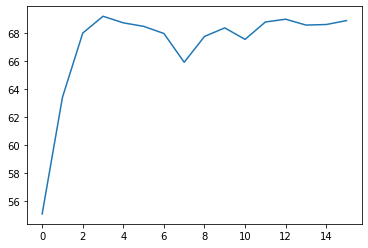

In [ ]:
print(f"Accuracy: {accuracies[-1]:.2f}%")

plt.plot([i for i in range(len(accuracies))], accuracies)
plt.show()

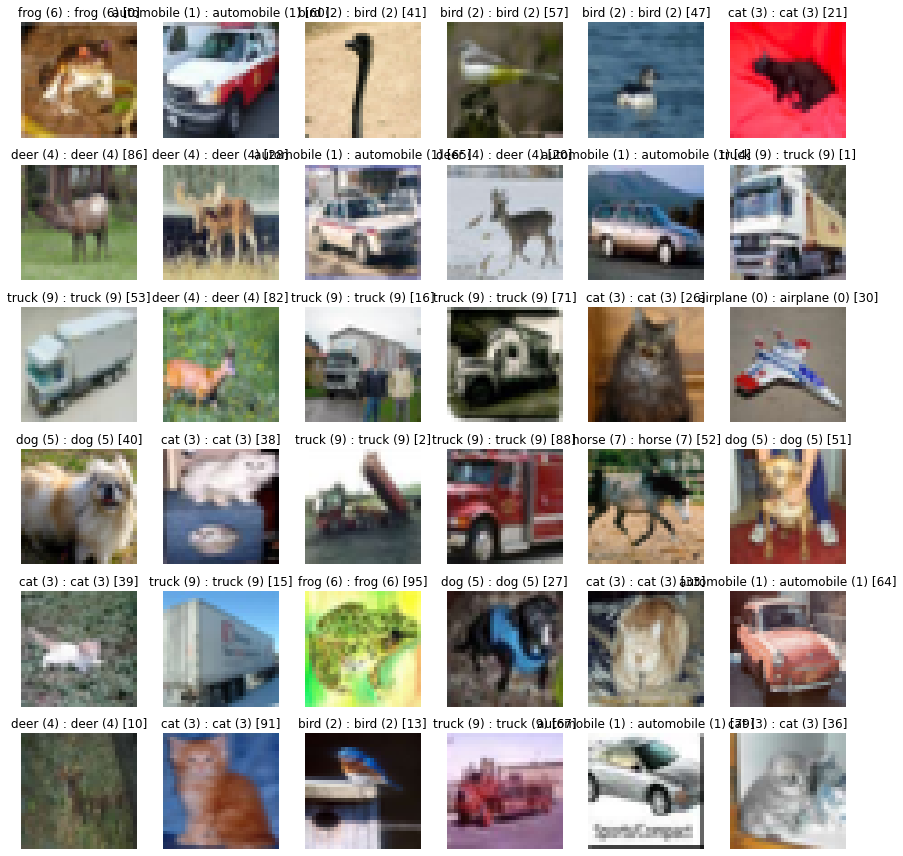

In [ ]:
pred = model(torch.from_numpy(X_orig[:100]).to(device)).argmax(axis=1)
utulek.show_img_ds(X_orig[:100].transpose((0, 2, 3, 1)), Y_orig[:100], pred, labels=labels, shape=(6, 6))

In [ ]:
import dill
import os


os.makedirs(".data/cnn-1.ipynb", exist_ok=True)

with open(".data/cnn-1.ipynb/model.dill", "wb") as file:
    dill.dump(model, file)